In [3]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
%matplotlib inline


from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout
from keras.optimizers import Adam ,RMSprop
from keras import  backend as K

from subprocess import check_output


In [4]:
from keras.datasets import mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))

11490434/11490434 [==============================] - 0s 0us/step
Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


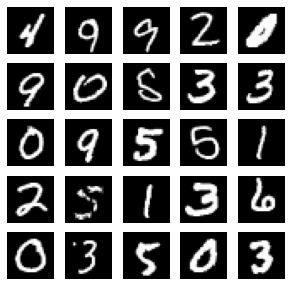

In [8]:

indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

### ANN

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical, plot_model

In [10]:
num_labels = len(np.unique(y_train))

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [13]:
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

In [14]:
batch_size = 128
hidden_units = 256
dropout = 0.45

In [15]:
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

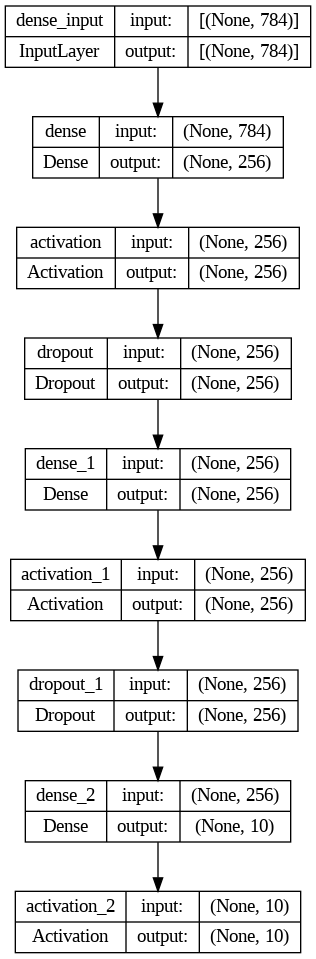

In [17]:
plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

In [18]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.fit(x_train, y_train, epochs=3, batch_size=batch_size)

Epoch 1/3
469/469 [==============================] - 7s 11ms/step - loss: 0.4308 - accuracy: 0.8669
Epoch 2/3
469/469 [==============================] - 5s 11ms/step - loss: 0.2003 - accuracy: 0.9404
Epoch 3/3
469/469 [==============================] - 5s 10ms/step - loss: 0.1528 - accuracy: 0.9540


In [20]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

79/79 [==============================] - 0s 4ms/step - loss: 0.0898 - accuracy: 0.9712

Test accuracy: 97.1%


In [21]:
from keras.regularizers import l2
model.add(Dense(hidden_units,
                kernel_regularizer=l2(0.001),
                input_dim=input_size))

### CNN

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [35]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


2    63
0    56
4    54
9    53
1    50
3    48
7    47
6    46
5    42
8    41
Name: label, dtype: int64

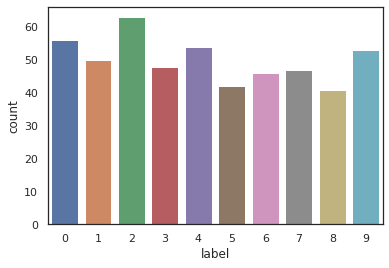

In [36]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [37]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [39]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [40]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [41]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [42]:
# Set the random seed
random_seed = 2

In [43]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

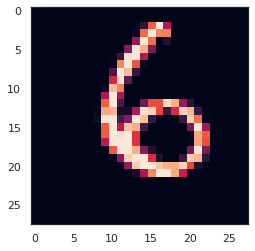

In [44]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

Model Implementation

In [45]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [46]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [47]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [48]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [54]:
epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [55]:
# Without data augmentation i obtained an accuracy of 0.98114
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/10
6/6 - 3s - loss: 0.1523 - accuracy: 0.9533 - val_loss: 0.3469 - val_accuracy: 0.9000 - 3s/epoch - 525ms/step
Epoch 2/10
6/6 - 3s - loss: 0.1074 - accuracy: 0.9556 - val_loss: 0.4166 - val_accuracy: 0.8800 - 3s/epoch - 499ms/step
Epoch 3/10
6/6 - 3s - loss: 0.1202 - accuracy: 0.9578 - val_loss: 0.4320 - val_accuracy: 0.8800 - 3s/epoch - 515ms/step
Epoch 4/10
6/6 - 4s - loss: 0.0795 - accuracy: 0.9822 - val_loss: 0.5058 - val_accuracy: 0.8600 - 4s/epoch - 717ms/step
Epoch 5/10
6/6 - 3s - loss: 0.1100 - accuracy: 0.9644 - val_loss: 0.4178 - val_accuracy: 0.9000 - 3s/epoch - 508ms/step
Epoch 6/10
6/6 - 3s - loss: 0.0605 - accuracy: 0.9644 - val_loss: 0.6701 - val_accuracy: 0.9000 - 3s/epoch - 497ms/step
Epoch 7/10
6/6 - 4s - loss: 0.0591 - accuracy: 0.9778 - val_loss: 0.6396 - val_accuracy: 0.9000 - 4s/epoch - 605ms/step
Epoch 8/10
6/6 - 4s - loss: 0.0549 - accuracy: 0.9800 - val_loss: 0.7968 - val_accuracy: 0.8000 - 4s/epoch - 627ms/step
Epoch 9/10
6/6 - 3s - loss: 0.1692 - acc

In [56]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [57]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10


<ipython-input-57-54b73dab410d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


5/5 - 6s - loss: 0.8339 - accuracy: 0.7747 - val_loss: 0.2857 - val_accuracy: 0.9000 - lr: 0.0010 - 6s/epoch - 1s/step
Epoch 2/10


5/5 - 3s - loss: 0.6376 - accuracy: 0.7802 - val_loss: 0.2771 - val_accuracy: 0.8600 - lr: 0.0010 - 3s/epoch - 517ms/step
Epoch 3/10


5/5 - 3s - loss: 0.6299 - accuracy: 0.7912 - val_loss: 0.2059 - val_accuracy: 0.8800 - lr: 0.0010 - 3s/epoch - 534ms/step
Epoch 4/10


5/5 - 3s - loss: 0.4374 - accuracy: 0.8516 - val_loss: 0.2468 - val_accuracy: 0.9000 - lr: 0.0010 - 3s/epoch - 528ms/step
Epoch 5/10


5/5 - 3s - loss: 0.4734 - accuracy: 0.8214 - val_loss: 0.2071 - val_accuracy: 0.9000 - lr: 0.0010 - 3s/epoch - 529ms/step
Epoch 6/10


5/5 - 4s - loss: 0.4475 - accuracy: 0.8571 - val_loss: 0.3009 - val_accuracy: 0.8800 - lr: 0.0010 - 4s/epoch - 704ms/step
Epoch 7/10


5/5 - 3s - loss: 0.3915 - accuracy: 0.8681 - val_loss: 0.1589 - val_accuracy: 0.9200 - lr: 0.0010 - 3s/epoch - 530ms/step
Epoch 8/10


5/5 - 3s - loss: 0.3822 - accuracy: 0.8736 - val_loss: 0.2176 - val_accuracy: 0.9200 - lr: 0.0010 - 3s/epoch - 533ms/step
Epoch 9/10


5/5 - 4s - loss: 0.4783 - accuracy: 0.8681 - val_loss: 0.2154 - val_accuracy: 0.9200 - lr: 0.0010 - 4s/epoch - 766ms/step
Epoch 10/10


5/5 - 3s - loss: 0.4074 - accuracy: 0.8874 - val_loss: 0.1401 - val_accuracy: 0.9000 - lr: 0.0010 - 3s/epoch - 524ms/step


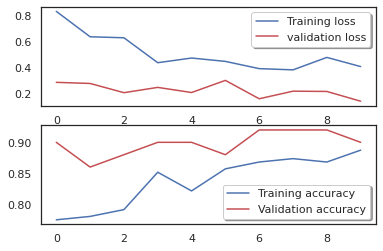

In [60]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


2/2 [==============================] - 0s 62ms/step


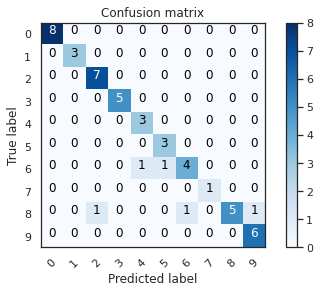

In [61]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Classification

In [67]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)


2.11.0


In [68]:
# Set common constants
this_repo_url = 'https://github.com/arunkumarramanan/mit-deep-learning/raw/master/'
this_tutorial_url = this_repo_url + 'tutorial_deep_learning_basics'

In [69]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# reshape images to specify that it's a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [70]:
def preprocess_images(imgs): # should work for both a single image and multiple images
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape # make sure images are 28x28 and single-channel (grayscale)
    return imgs / 255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

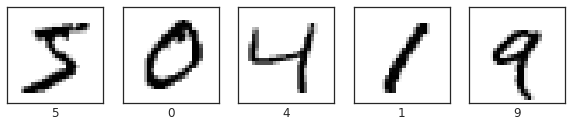

In [71]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])a
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

In [73]:
model = keras.Sequential()
# 32 convolution filters used each of size 3x3
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 64 convolution filters used each of size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))
# choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
# flatten since too many dimensions, we only want a classification output
model.add(Flatten())
# fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
# one more dropout
model.add(Dropout(0.5))
# output a softmax to squash the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

In [76]:
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [77]:
history = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 185s 97ms/step - loss: 0.1929 - accuracy: 0.9415
Epoch 2/5
1875/1875 [==============================] - 176s 94ms/step - loss: 0.0800 - accuracy: 0.9759
Epoch 3/5
1875/1875 [==============================] - 181s 96ms/step - loss: 0.0604 - accuracy: 0.9818
Epoch 4/5
1875/1875 [==============================] - 176s 94ms/step - loss: 0.0513 - accuracy: 0.9845
Epoch 5/5
1875/1875 [==============================] - 177s 94ms/step - loss: 0.0414 - accuracy: 0.9873


In [78]:
print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

(10000, 28, 28, 1)
313/313 [==============================] - 10s 30ms/step - loss: 0.0298 - accuracy: 0.9906
Test accuracy: 0.9905999898910522
